## Stock Price Prediction using LSTM Recurrent Neural Networks

### Overview
In this project, we'll build an LSTM Recurrent Neural Network to predict the Closing stock price of the Big 4 Tech companies, 
Google, Amazon, Facebook and Apple.

We'll be doing the following steps to complete our project:
- We'll first collect the data 
- Then preprocess the data so that it can be used to train our model
- Split the data into training set(used to train the model) and test set(used to check the performance of the model)
- Build our Sequential LSTM RNN model using keras with TensorFlow backend
- Fit the model to our data
- Validate the performance of our model by testing it's performance on the test data

### Data
- The data has been imported from the Tiingo API
- The data of the stock prices for the last 5 years, i.e, from 2015 to 2020 has been taken 

In [1]:
# Libraries required for importing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_datareader as pdr
from pandas_datareader import data
import config

In [4]:
# API key
key = config.api_key

# loading data of the Big 4 Tech companies
google = pdr.get_data_tiingo('GOOGL', api_key = key)
Amazon = pdr.get_data_tiingo('AMZN', api_key = key)
Facebook = pdr.get_data_tiingo('FB', api_key = key)
Apple = pdr.get_data_tiingo('AAPL', api_key = key)

# converting the file to csv format
google.to_csv('GOOGL.csv')
Amazon.to_csv('AMZN.csv')
Facebook.to_csv('FB.csv')
Apple.to_csv('AAPL.csv')

# reading the files as a dataframe
google = pd.read_csv('GOOGL.csv')
Amazon = pd.read_csv('AMZN.csv')
Facebook = pd.read_csv('FB.csv')
Apple = pd.read_csv('AAPL.csv')

we'll be creating a dataframe taking the 'close price' of each company

In [5]:
# Dataframe
gafa = {'google':google['close'], 'amazon':Amazon['close'], 'fb':Facebook['close'], 'apple':Apple['close']}
data = pd.DataFrame(gafa)
data.head()

,google,amazon,fb,apple
0,731.12,608.61,103.77,115.28
1,732.82,611.01,103.70,114.55
2,736.92,617.10,104.20,119.27
3,744.85,626.55,104.88,120.53
4,737.39,625.90,101.97,119.50


# Google
Now, we'll start with first building a model to predict the closing stock price of google. 

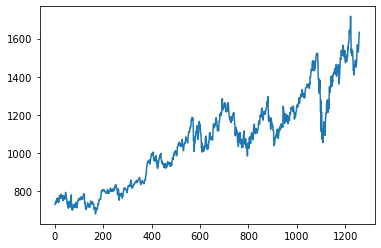

In [6]:
plt.plot(data['google'])

### Data Preprocessing

In [7]:
# Scaling the data so that it is in the range of 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
goog = scaler.fit_transform(np.array(data['google']).reshape(-1,1))

In [8]:
len(goog)

1259

In [9]:
len(data['google'])

1259

In [10]:
# splitting the data into train set and test set
train_data = goog[0:(int(len(goog)*0.90))]
test_data = goog[len(train_data):len(goog)]

In [11]:
len(train_data), len(test_data)

(1133, 126)

we'll create a function to create a document matrix from our data with X features and a Y lable with specified timesteps which 
indicates the number of previous data points to be considered to predict the next value

In [12]:
# function to create a document matrix of our data
def model_data(data, timesteps):
    x = []
    y = []
    for i in range(len(data)-timesteps-1):
        x.append(data[i:(i+timesteps), 0])
        y.append(data[i+timesteps, 0])
    
    return np.array(x), np.array(y)

In [13]:
timesteps = 30
X_train, y_train = model_data(train_data, timesteps)
X_test, y_test = model_data(test_data, timesteps)

In [14]:
X_train

array([[0.0482316 , 0.04987214, 0.05382871, ..., 0.08401448, 0.09463932,
        0.08863691],
       [0.04987214, 0.05382871, 0.0614813 , ..., 0.09463932, 0.08863691,
        0.0907117 ],
       [0.05382871, 0.0614813 , 0.05428227, ..., 0.08863691, 0.0907117 ,
        0.07856212],
       ...,
       [0.5732497 , 0.51122799, 0.41535344, ..., 0.57694572, 0.55972014,
        0.51244391],
       [0.51122799, 0.41535344, 0.5144801 , ..., 0.55972014, 0.51244391,
        0.557076  ],
       [0.41535344, 0.5144801 , 0.37815199, ..., 0.51244391, 0.557076  ,
        0.56938963]])

In [15]:
print(X_train.shape), print(X_test.shape)

(1102, 30)
(95, 30)


(None, None)

Reshaping the data in 2D array into a 3D array

In [16]:
# reshaping the data to make it compatible with the LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
print(X_train.shape), print(X_test.shape)

(1102, 30, 1)
(95, 30, 1)


(None, None)

### Building The LSTM Recurrent Neural Network

In [20]:
# libraries required to build a LSTM Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

We'll create a Neural Network with one input layer, two hidden layers and one output layer. We'll use mean squared error as 
the loss function and 'Adam' as an optimizer.

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (30, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
# model fitting
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=30,verbose=1)

Train on 1100 samples, validate on 95 samples
Epoch 1/100
1100/1100 [==============================] - 9s 8ms/sample - loss: 0.0177 - val_loss: 0.0028
Epoch 2/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0017 - val_loss: 0.0065
Epoch 3/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0015 - val_loss: 0.0041
Epoch 4/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0014 - val_loss: 0.0032
Epoch 5/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0014 - val_loss: 0.0026
Epoch 6/100
1100/1100 [==============================] - 3s 2ms/sample - loss: 0.0014 - val_loss: 0.0032
Epoch 7/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0012 - val_loss: 0.0032
Epoch 8/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0011 - val_loss: 0.0029
Epoch 9/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 0.0012 - val_loss: 0.0033
Epoch 10/

In [20]:
# predicting the y label for train set and test set
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [21]:
test_predict.shape

(95, 1)

In [22]:
y_test = y_test.reshape(-1, 1)

In [23]:
y_test.shape

(95, 1)

In [24]:
# calculating the mean squared error of the training set
import math
from sklearn.metrics import mean_squared_error
rmse_train = math.sqrt(mean_squared_error(y_train,train_predict))
print("The Root mean squared error for the training set is {}".format(rmse_train))

# calculating the mean squared error of the test set
rmse_test = math.sqrt(mean_squared_error(y_test,test_predict))
print("The Root mean squared error for the test set is {}".format(rmse_test))

The Root mean squared error for the training set is 0.018747853367167423
The Root mean squared error for the test set is 0.03421227952273131


In [25]:
# transforming the values to their original form so that they can be comapred with the y label of train set and test set
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

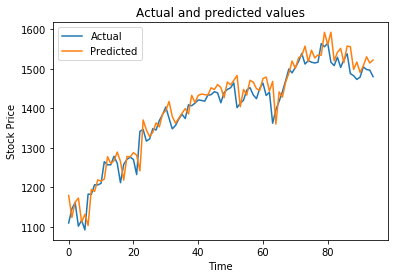

In [26]:
plt.plot(y_test, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')

plt.title('Actual and predicted values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### <b>Creating a function to apply the model to predict the closing stock price of the other tech comapnies</b>

In [27]:
# To fit the data
def close_price(data):
    df = scaler.fit_transform(np.array(data).reshape(-1,1))
    # splitting the data into train set and test set
    train_data = df[0:(int(len(df)*0.90))]
    test_data = df[len(train_data):len(df)]
    # creating a document matrix with x(time steps) number of features and a y label
    timesteps = 30
    X_train, y_train = model_data(train_data, timesteps)
    X_test, y_test = model_data(test_data, timesteps)
    # reshaping the data to make it compatible with the LSTM model
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # model fitting
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=30,verbose=1)
    # predicting the y label for train set and test set
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # rmse of train set
    rmse_train = math.sqrt(mean_squared_error(y_train,train_predict))
    print("The Root mean squared error for the training set is {}".format(rmse_train))
    # rmse of test set
    rmse_test = math.sqrt(mean_squared_error(y_test,test_predict))
    print("The Root mean squared error for the test set is {}".format(rmse_test))
    
    # transforming the values to their original form so that they can be comapred with the y label of train set and test set
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plotting the predicted values against the actual values
    plt.plot(y_test, label = 'Actual')
    plt.plot(test_predict, label = 'Predicted')

    plt.title('Actual and predicted values')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

## Amazon

Text(0, 0.5, 'Close Price')

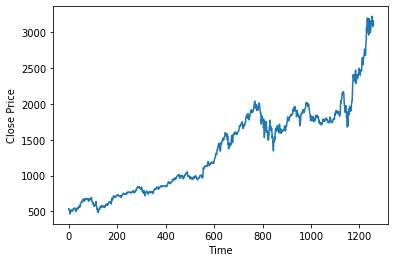

In [28]:
plt.plot(data['amazon'])
plt.xlabel('Time')
plt.ylabel('Close Price')

Train on 1100 samples, validate on 95 samples
Epoch 1/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 1.0337e-04 - val_loss: 6.1296e-04
Epoch 2/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 9.2094e-05 - val_loss: 5.5053e-04
Epoch 3/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 8.3765e-05 - val_loss: 5.8890e-04
Epoch 4/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 7.9380e-05 - val_loss: 8.0764e-04
Epoch 5/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 8.2768e-05 - val_loss: 7.4388e-04
Epoch 6/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 8.4204e-05 - val_loss: 5.5474e-04
Epoch 7/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 8.3392e-05 - val_loss: 6.9060e-04
Epoch 8/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 8.7002e-05 - val_loss: 6.3064e-04
Epoch 9/100
1100/1100 [===========================

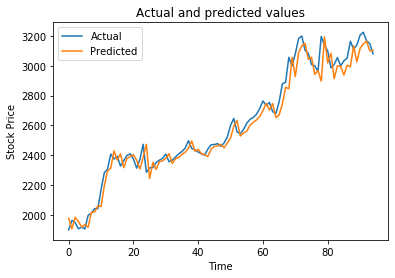

In [29]:
close_price(data['amazon'])

# Facebook

Text(0, 0.5, 'Close Price')

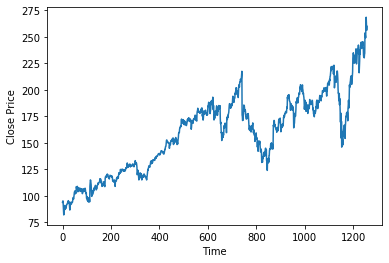

In [30]:
plt.plot(data['fb'])
plt.xlabel('Time')
plt.ylabel('Close Price')

Train on 1100 samples, validate on 95 samples
Epoch 1/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 3.1851e-04 - val_loss: 0.0010
Epoch 2/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 3.5112e-04 - val_loss: 9.3630e-04
Epoch 3/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 3.5094e-04 - val_loss: 0.0013
Epoch 4/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 2.8373e-04 - val_loss: 9.5846e-04
Epoch 5/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 2.6151e-04 - val_loss: 0.0011
Epoch 6/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 2.7668e-04 - val_loss: 0.0013
Epoch 7/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 2.7410e-04 - val_loss: 0.0011
Epoch 8/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 2.8968e-04 - val_loss: 9.8757e-04
Epoch 9/100
1100/1100 [==============================] - 2s 2ms/sample

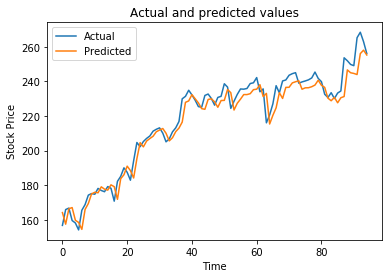

In [31]:
close_price(data['fb'])

# Apple

Text(0, 0.5, 'Close Price')

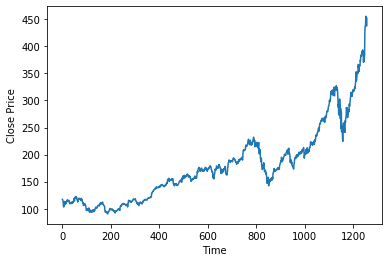

In [32]:
plt.plot(data['apple'])
plt.xlabel('Time')
plt.ylabel('Close Price')

Train on 1100 samples, validate on 95 samples
Epoch 1/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 7.2236e-05 - val_loss: 7.1419e-04
Epoch 2/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.9139e-05 - val_loss: 8.1924e-04
Epoch 3/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.8437e-05 - val_loss: 7.5047e-04
Epoch 4/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.6548e-05 - val_loss: 9.4226e-04
Epoch 5/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.7037e-05 - val_loss: 8.1683e-04
Epoch 6/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.8460e-05 - val_loss: 8.3011e-04
Epoch 7/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.5618e-05 - val_loss: 9.2178e-04
Epoch 8/100
1100/1100 [==============================] - 2s 2ms/sample - loss: 5.8920e-05 - val_loss: 9.5334e-04
Epoch 9/100
1100/1100 [===========================

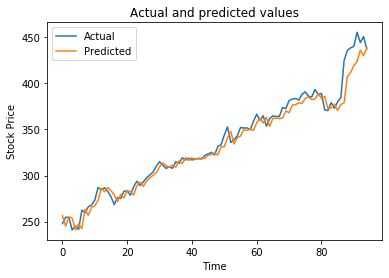

In [33]:
close_price(data['apple'])

Our model predicted the closing stock price of the Big 4 Tech companies with a <b>Root mean squared error</b> of less than 
<b>0.04</b>